<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Use scikit-learn to predict the price of a car</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
   <tr style="border: none">
      <th style="border: none"><img src="https://github.com/pmservice/wml-sample-notebooks/blob/master/images/PredictingCarPrice.png?raw=true" width="600" alt="Icon"> </th>
   </tr>
</table>

This notebook gives an insight on how to handle regression problems in data science. In machine learning, regression is used when the target (the variable that will be predicted) is numerical. There are various regression algorithms that can be used to predict numerical data and you will compare the results of three of them below.

In this notebook, you will use a data set of auto imports to predict the price of a car. This data set has 205 records, and you will split them into the training and testing sets after the data is loaded and cleaned. You will learn what steps to take to explore and prepare the data, create a model, and use Watson Machine Learning Client to save and deploy the model. 

The notebook uses `scikit-learn 0.20` and `watson-machine-learning-client-V4`.

Some familiarity with Python is helpful. This notebook is compatible Watson Studio Desktop 1.1, Watson Machine Learning Server 1.1, and Python 3.6.

## Learning goals
- Load `csv` data.
- Display data by using PixieDust.
- Explore data:
    - Handle missing values.
    - Visualize data in order to find significant predictors.
- Prepare data for training:
    - Train-test split.
    - One-hot encoding.
    - Feature scaling.
- Create, compare, and evaluate models.
- Use grid search to tune the model hyperparameters.
- Use the Watson Machine Learning Client package:
    - Save, deploy, and score the selected model.

## Table of Contents
1. [Load and explore data](#loaddata) <br>
    1.1 [Explore data](#explore)<br>
    1.2 [EDA and Feature selection](#eda)
2. [Data preparation](#dataprep)<br>
    2.1 [One-hot encoding](#encoding)<br>
    2.2 [Feature scaling](#scaling)
3. [Model selection](#model)<br>
    3.1 [Compare and evaluate models](#compare)<br>
    3.2 [Grid search](#gridsearch)<br>
    3.3 [Evaluate final model](#evaluate)
4. [Setting up](#setup) <br>
    4.1 [Connecting to Watson Studio Desktop](#wsd) <br>
    4.2 [Connecting to Watson Machine Learning Server](#wmls) <br>
5. [Save the model](#save)<br>
6. [Deploy the selected model and score data](#deploy)<br>
    6.1 [Create an online deployment for the published model](#create)<br>
    6.2 [Score data](#score)<br>
    6.3 [Delete the deployment and model](#delete)
7. [Summary and next steps](#summary)

To get started on Watson Machine Learning (WML) Server, find documentation on installion and set up <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/wmls-install-over.html" target="_blank" rel="noopener no referrer">here</a>.

<a id='loaddata'></a>
## 1. Load and explore data

In this section, the following topics will be covered:
- 1.1 [Explore data](#explore)
- 1.2 [EDA and Feature selection](#eda)

<a id='explore'></a>
### 1.1 Explore data

Load the data from the <a href="https://archive.ics.uci.edu/ml/datasets/automobile" target="_blank" rel="noopener no referrer">Auto Imports Database</a> available on UCI Machine Learning. 

You can use PixieDust to display items such as tables. PixieDust is an IBM open source add-on tool for Jupyter Notebooks used to explore and visualize data in such a way that it's easy to share and gather information from.

<div class="alert alert-block alert-warning">
To simply hide the output of pip install instead, use <tt>-q</tt> after <tt>!pip install</tt>.
</div>

In [ ]:
# Install pixiedust.
!pip install --upgrade pixiedust

In [2]:
# Import modules.
import numpy as np
import pandas as pd
import pixiedust

# Load data and set column names.
cars_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data', 
                        names = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 
                                 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 
                                 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 
                                 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'])
display(cars_data.head(10))

symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,nan,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
3,nan,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
1,nan,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0
2,nan,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,15250.0
1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,17710.0
1,nan,audi,gas,std,four,wagon,fwd,front,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,18920.0
1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.4,8.3,140.0,5500.0,17,20,23875.0
2,192.0,bmw,gas,std,two,sedan,rwd,front,101.2,176.8,64.8,54.3,2395,ohc,four,108,mpfi,3.5,2.8,8.8,101.0,5800.0,23,29,16430.0


Here, you can see a preview of the first 10 rows of the data. You can look at the values to get a sense of each column's data type. Also, note the "?" values in some rows, you can infer that there are missing values in this data set. These will be handled later in this notebook. 

Run this cell to get a list of the columns and their automatically assigned data types.

In [3]:
# Observe column data types.
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

In [4]:
# Display the number of records and features.
print('Number of rows: {}'.format(len(cars_data)))
print('Number of columns: {}'.format(len(cars_data.columns)))

Number of rows: 205
Number of columns: 26


The data set has 205 records and 26 features. As you can see, some of the data types are incorrectly marked as objects due to the missing values (represented by "?"). This can be fixed by running the following code, which converts the data type of the selected columns to numeric, replacing each missing value "?" with NaN. 

In [5]:
# Fix column data types.
cars_data[['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']] = cars_data[['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']].apply(pd.to_numeric, errors='coerce', axis=1)
display(cars_data.head())

symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,nan,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
3,nan,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
1,nan,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0


The missing values in each column can be counted by using the following code.

In [6]:
# Check for missing values.
cars_data.isnull().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          0
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

The output shows us that the label, *price*,  is missing in 4 rows. Since you cannot make and evaluate predictions without the labels, those rows can be removed using the cell below. 

In [7]:
# Drop rows with missing target values.
cars_data.dropna(subset=['price'], inplace = True)
cars_data.isnull().sum()

symboling             0
normalized-losses    37
make                  0
fuel-type             0
aspiration            0
num-of-doors          0
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

Import the packages below to use for the exploratory data analysis.

In [ ]:
# Import visualization packages.
!pip install --upgrade matplotlib
!pip install --upgrade seaborn

You can visualize the price distribution of the cars by running the following cell.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'count')

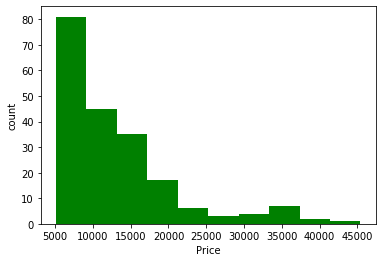

In [10]:
# Distribution of target value price.
plt.hist(x = cars_data['price'], bins = 10, color = 'green')
plt.xlabel('Price')
plt.ylabel('count')

Now, look at the distribution of the columns *with* their missing values and compare them to the column distributions once the missing values are replaced by the the column **mean**.

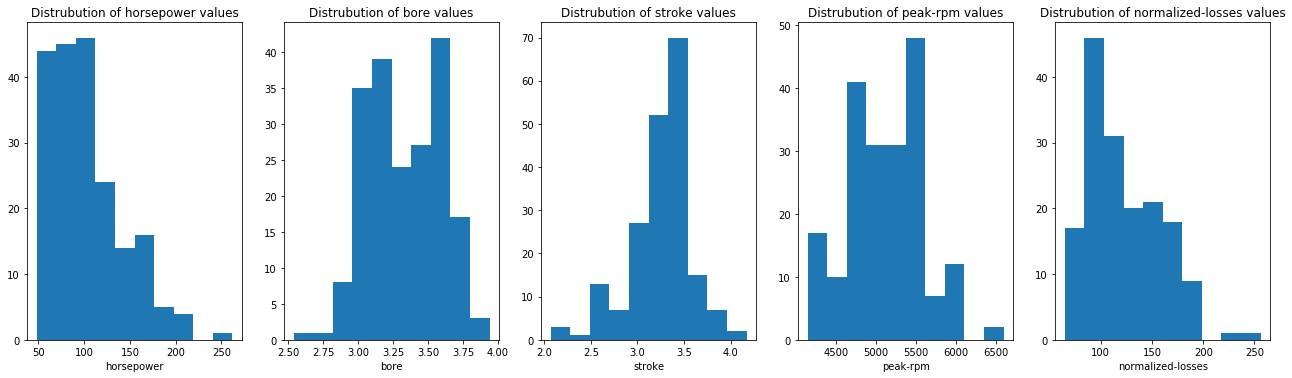

In [11]:
# Histograms of columns with missing values.
f, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(18,5))
f.tight_layout()
ax = [ax1, ax2, ax3, ax4, ax5]
col = ['horsepower', 'bore', 'stroke', 'peak-rpm', 'normalized-losses']
for i in range (len(ax)):
    x_hist = cars_data[col[i]].dropna(inplace=False)

    ax[i].hist(x = x_hist, bins = 10)
    ax[i].set_xlabel(col[i])
    ax[i].set_title('Distrubution of ' + col[i] + ' values')

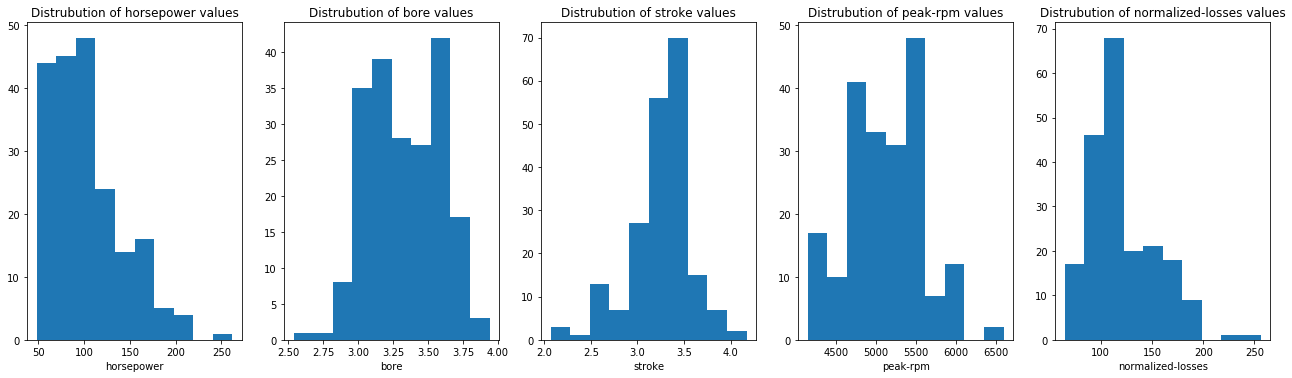

In [12]:
# Histograms of columns with adjusted missing values.
f, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(18,5))
f.tight_layout()
ax = [ax1, ax2, ax3, ax4, ax5]
col = ['horsepower', 'bore', 'stroke', 'peak-rpm', 'normalized-losses']
for i in range (len(ax)):
    x_hist = cars_data[col[i]].fillna(value=cars_data[col[i]].mean(), inplace=False)
    
    ax[i].hist(x = x_hist, bins = 10)
    ax[i].set_xlabel(col[i])
    ax[i].set_title('Distrubution of ' + col[i] + ' values')

The distribution does not change significantly for *horsepower*, *bore*, *stroke*, and *peak-rpm*, so for these columns, this method can be used to replace the missing values  without significantly affecting the predictions.

In [13]:
for col in ['horsepower', 'bore', 'stroke', 'peak-rpm']:
    cars_data[col].fillna(cars_data[col].mean(), inplace=True)

### 1.2 EDA and Feature selection<a id='eda'></a>

In order to make accurate predictions, you need to select the significant numerical predictors by choosing the features most highly correlated to the label, *price*.

In [14]:
# Correlation of numerical values.
cars_data.corr()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
symboling,1.000000,0.528667,-0.535987,-0.365404,-0.242423,-0.550160,-0.233118,-0.110581,-0.139896,-0.007992,-0.182196,0.075790,0.279719,-0.035527,0.036233,-0.082391
normalized-losses,0.528667,1.000000,-0.074362,0.023220,0.105073,-0.432335,0.119893,0.167365,-0.033506,0.066413,-0.132654,0.295772,0.264597,-0.258502,-0.210768,0.203254
wheel-base,-0.535987,-0.074362,1.000000,0.876024,0.814507,0.590742,0.782097,0.572027,0.493203,0.157964,0.250313,0.371250,-0.360233,-0.470606,-0.543304,0.584642
length,-0.365404,0.023220,0.876024,1.000000,0.857170,0.492063,0.880665,0.685025,0.608941,0.123913,0.159733,0.579731,-0.286035,-0.665192,-0.698142,0.690628
width,-0.242423,0.105073,0.814507,0.857170,1.000000,0.306002,0.866201,0.729436,0.544879,0.188814,0.189867,0.615006,-0.245852,-0.633531,-0.680635,0.751265
height,-0.550160,-0.432335,0.590742,0.492063,0.306002,1.000000,0.307581,0.074694,0.180327,-0.060822,0.259737,-0.086941,-0.309913,-0.049800,-0.104812,0.135486
curb-weight,-0.233118,0.119893,0.782097,0.880665,0.866201,0.307581,1.000000,0.849072,0.644041,0.167412,0.156433,0.757994,-0.279350,-0.749543,-0.794889,0.834415
engine-size,-0.110581,0.167365,0.572027,0.685025,0.729436,0.074694,0.849072,1.000000,0.572516,0.205806,0.028889,0.822649,-0.256753,-0.650546,-0.679571,0.872335
bore,-0.139896,-0.033506,0.493203,0.608941,0.544879,0.180327,0.644041,0.572516,1.000000,-0.055390,0.001250,0.566838,-0.267338,-0.582121,-0.591390,0.543154
stroke,-0.007992,0.066413,0.157964,0.123913,0.188814,-0.060822,0.167412,0.205806,-0.055390,1.000000,0.187854,0.097815,-0.063720,-0.034079,-0.034741,0.082267


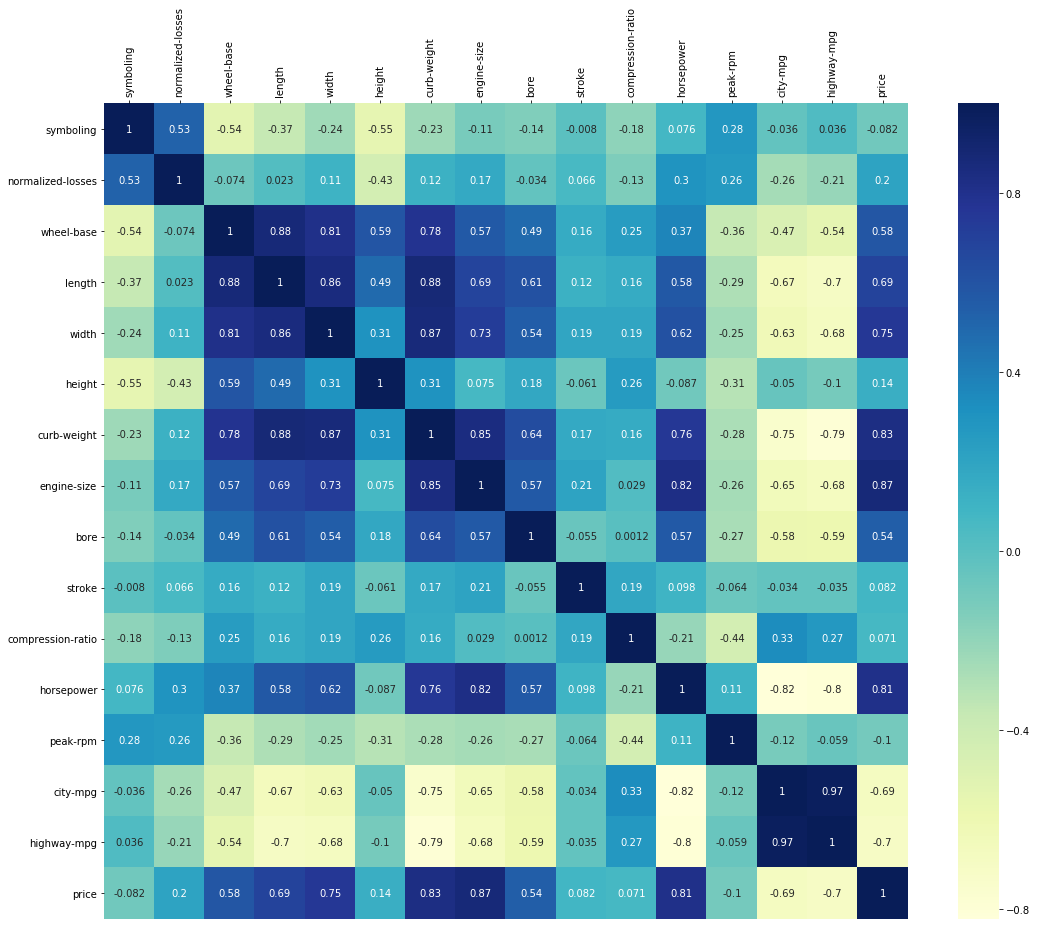

In [15]:
# Plot a correlation heatmap.
plt.subplots(figsize=(18,15))
hm1 = sns.heatmap(cars_data.corr(), annot=True, cmap='YlGnBu')
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=90)
hm1.xaxis.set_ticks_position('top')

Although the *normalized-losses* column has many NaNs, it doesn't appear to be a significant predictor. So, the missing values do not need to be filled in this case. 

By plotting the correlation heatmap of the numerical columns with the target *price*, you can pick out the significant numerical features/predictors. The features that are highly correlated are also eliminated **(ex: > 0.95)**. Therefore, you can choose *width*, *engine-size*, and *highway-mpg* as the numerical predictors for the model.

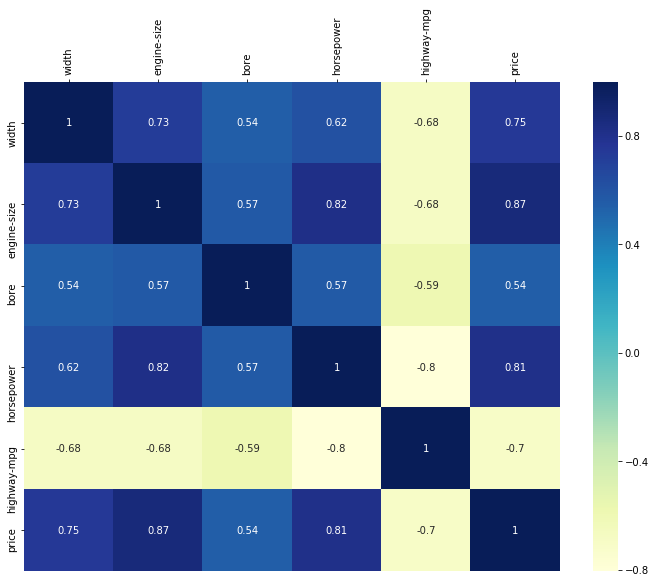

In [16]:
# Plot correlation heatmap of selected numerical features.
plt.subplots(figsize=(12, 9))
hm2 = sns.heatmap(cars_data[['width', 'engine-size', 'bore', 'horsepower', 'highway-mpg', 'price']].corr(), annot=True, cmap='YlGnBu')
hm2.set_xticklabels(hm2.get_xticklabels(), rotation=90)
hm2.xaxis.set_ticks_position('top')

By plotting the boxplots of each categorical column against the price, you can pick out the significant features. More variation in the boxplot implies higher significance. Therefore you can choose *make*, *engine-location*, *num-of-cylinders*, and *fuel-system* as predictors for the model.

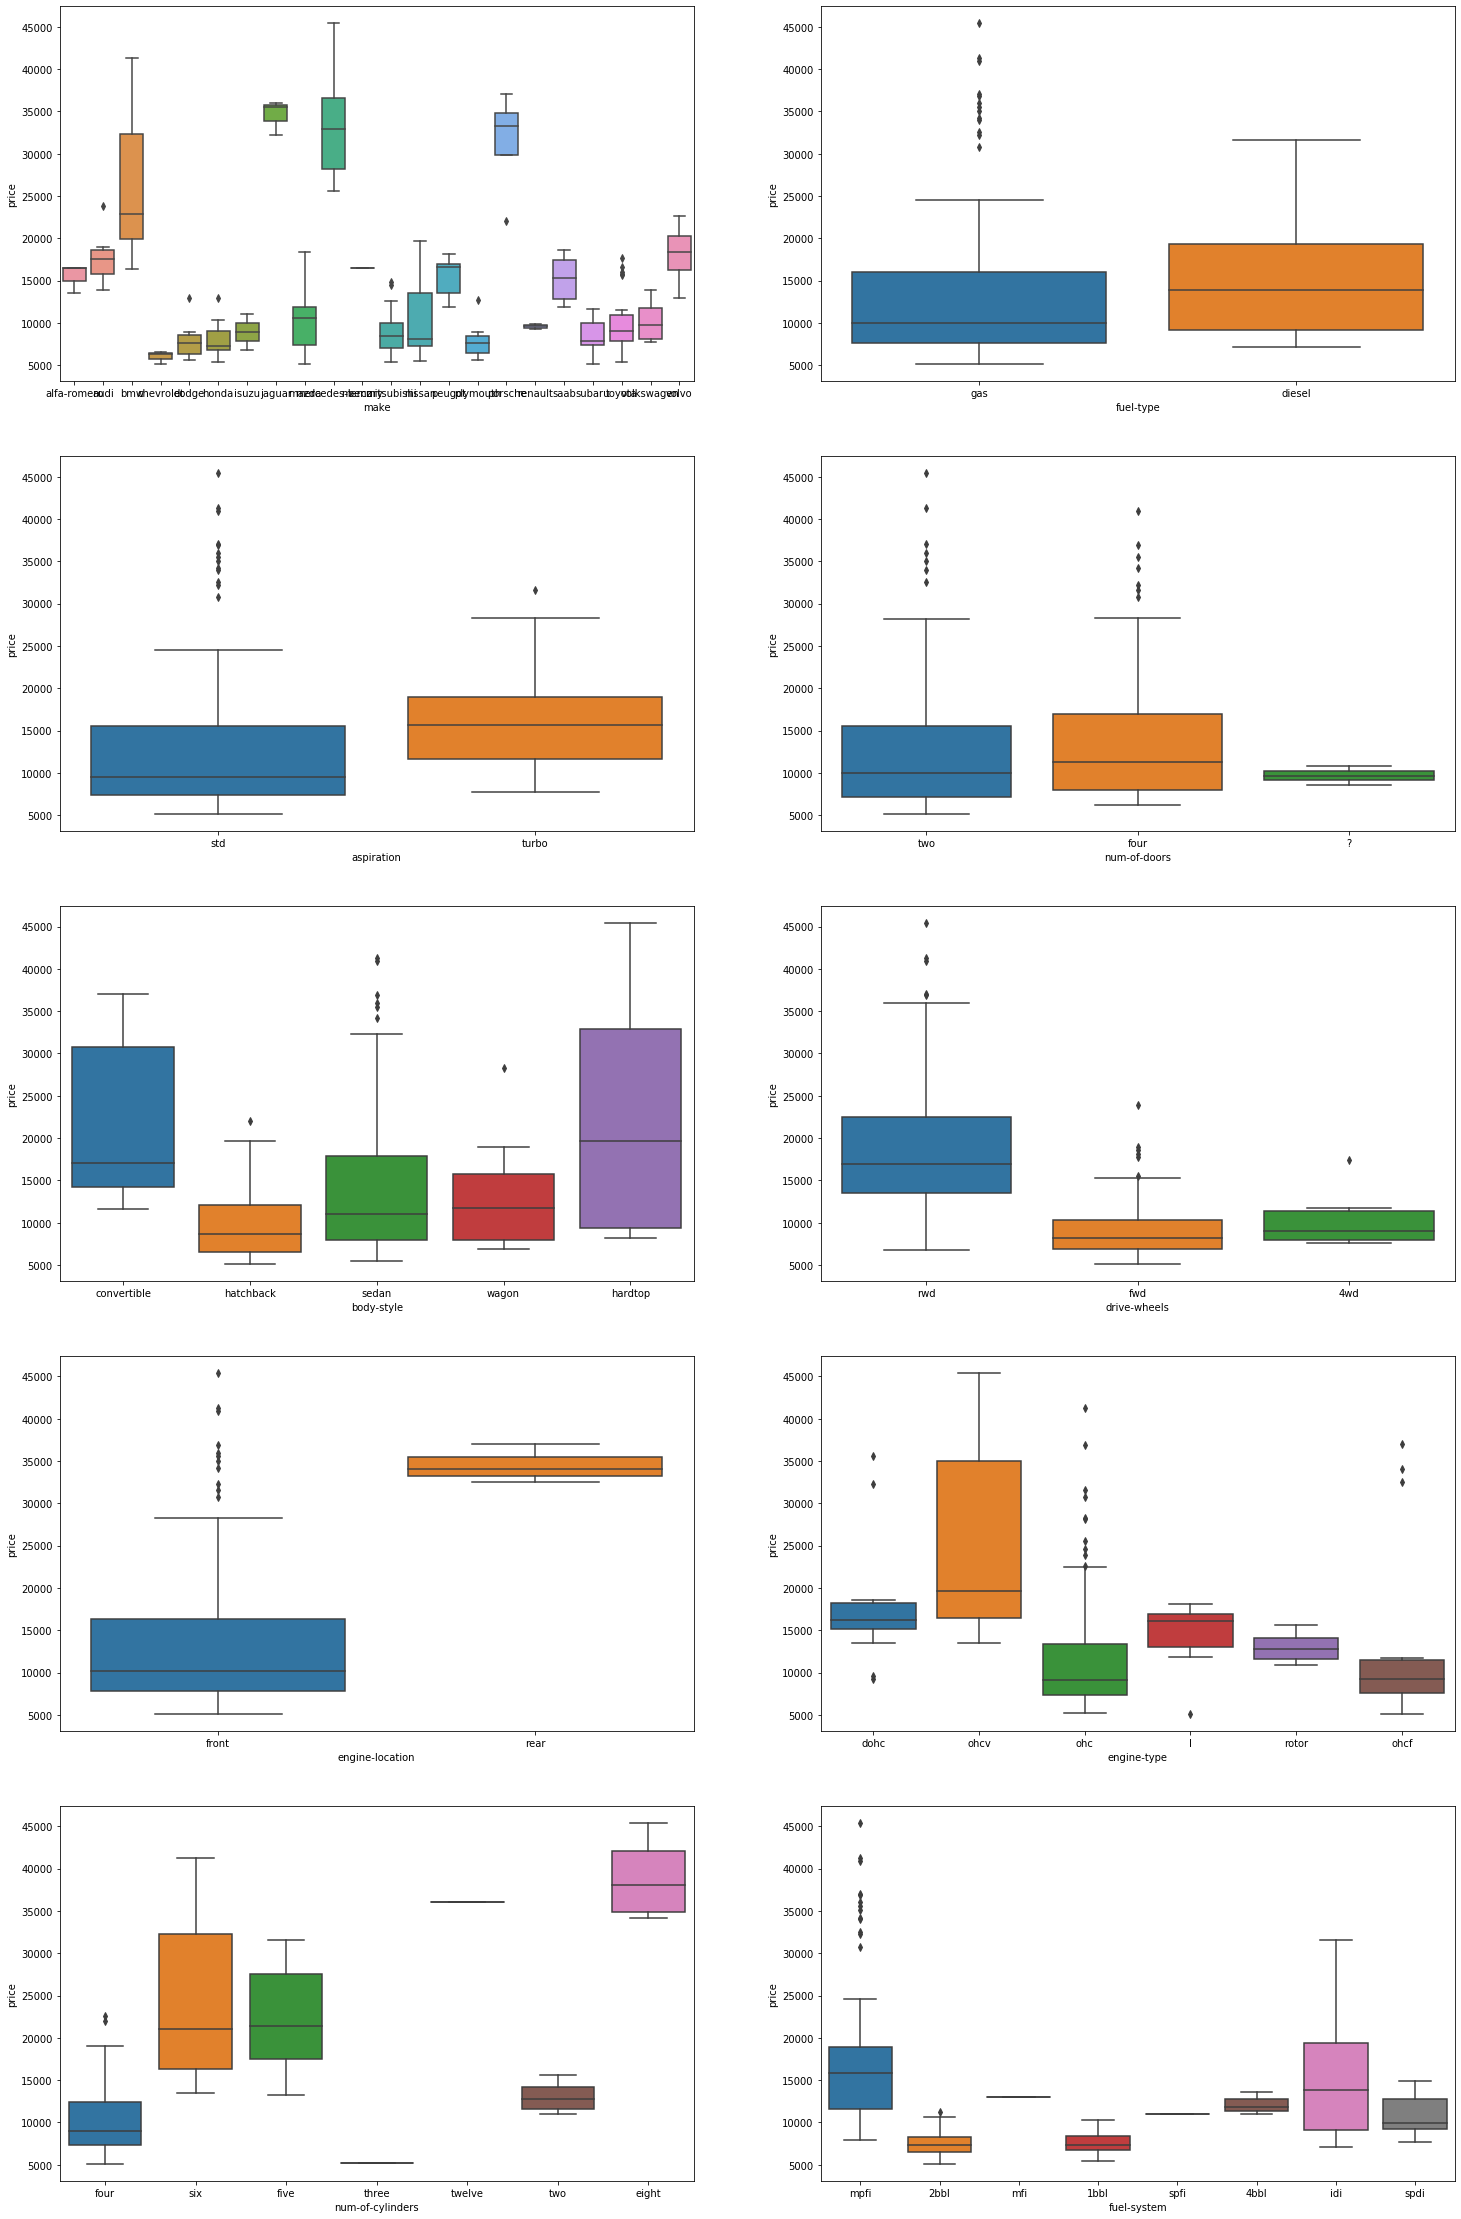

In [17]:
# Plot boxplots of categorical columns.
cat_list = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system']
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(25, 40))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

for i in range(len(cat_list)):
    sns.boxplot(x = cat_list[i], y = 'price', data=cars_data, ax=ax[i])

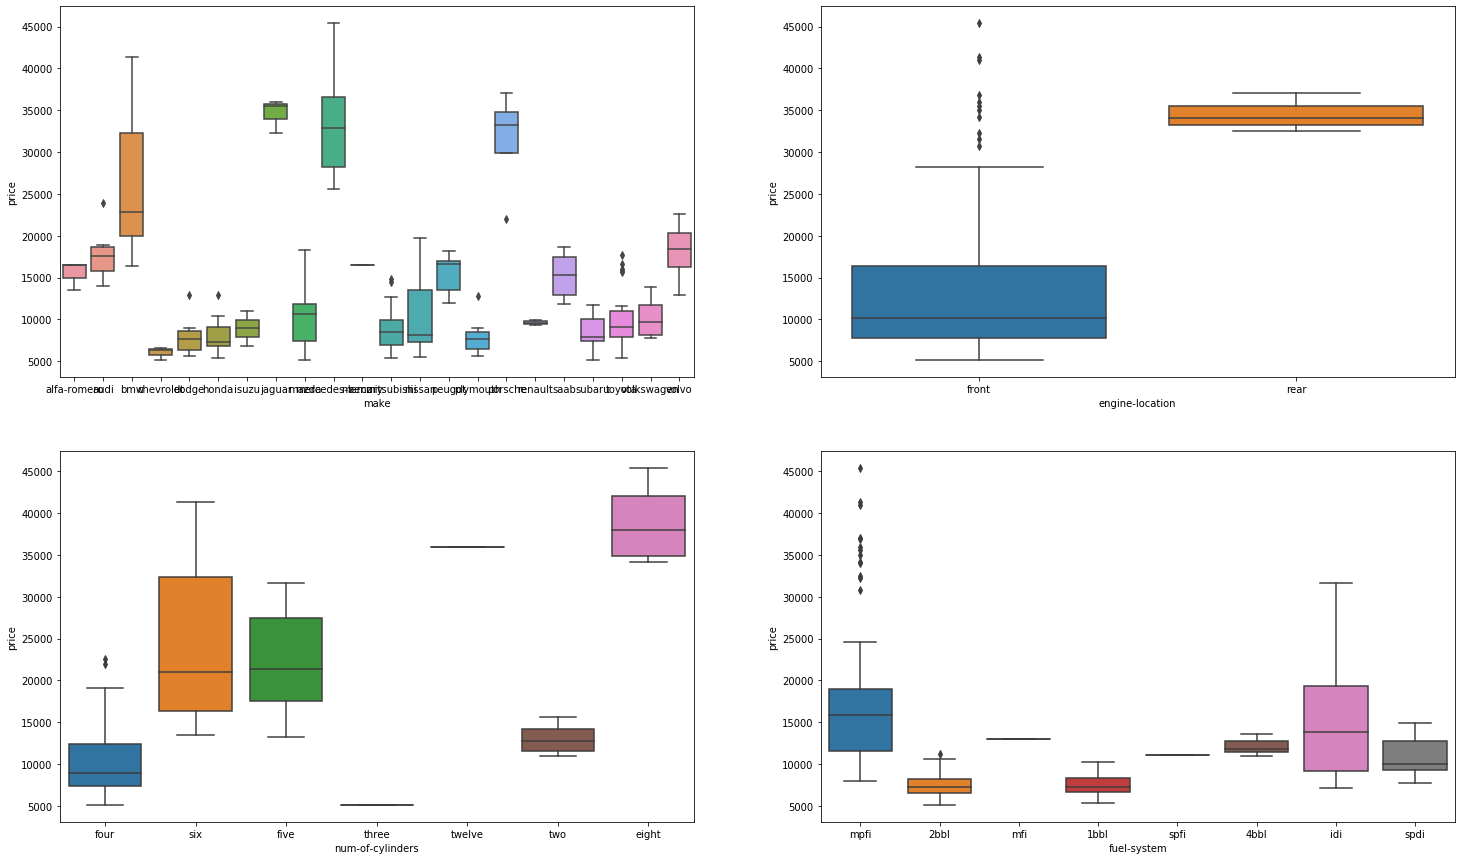

In [18]:
# Plot boxplots of selected categorical columns:
# drive-wheels, engine-type.
cat_list2 = ['make', 'engine-location', 'num-of-cylinders', 'fuel-system']
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))
ax = [ax1, ax2, ax3, ax4]

for i in range(len(cat_list2)):
    sns.boxplot(x = cat_list2[i], y = 'price', data=cars_data, ax=ax[i])

Now, the significant features *(make*, *engine-location*, *width*, *num-of-cylinders*, *engine-size*, *fuel-system*, and *highway-mpg)* and label *(price)* can be used to make the predictions.

<a id = 'dataprep'></a>
## 2. Data Preparation

This section will cover:
- 2.1 [One-hot encoding](#encoding)
- 2.2 [Feature scaling](#scaling)

### 2.1 One-hot encoding<a id='encoding'></a>

Now, set the predictors to variable `X` and the target/label to variable `y`.

In [19]:
# Feature selection.
X = cars_data[['make', 'engine-location', 'width', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'horsepower', 'highway-mpg']]
y = cars_data.iloc[:, 25]

Many models take only numerical values as input. So, using the following code, the categorical columns are converted to dummy variables, a process called **one-hot encoding**. This means that each column is split into it's various categories, with a column of binary values for each category. One category/column is always omitted from each set of categories to prevent multicollinearity. 

For example, *engine-location* as 2 categories: *front* and *rear*. This is converted into 2 columns - one for each category - but one is dropped, leaving only *engine-location_rear*. The model will infer from this that $1$ represents the *rear* category and $0$ represents the *front* category.

In [20]:
# One-hot encoding.
X = pd.get_dummies(X, columns=['make', 'engine-location', 'num-of-cylinders', 'fuel-system'], drop_first=True)
X_copy = X.copy()

In [21]:
X = X.values

You can check the one-hot encoded columns.

In [22]:
with pd.option_context('display.max_columns', None):
    display(X_copy.head())

width,engine-size,bore,horsepower,highway-mpg,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,make_mercury,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_porsche,make_renault,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,engine-location_rear,num-of-cylinders_five,num-of-cylinders_four,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
64.1,130.0,3.47,111.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
64.1,130.0,3.47,111.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
65.5,152.0,2.68,154.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66.2,109.0,3.19,102.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66.4,136.0,3.19,115.0,22.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Split the data set into training and test data sets.
- The train data set, which is the largest group, will be used for training
- The test data set will be used for model evaluation and is used to test the assumptions of the model

In [ ]:
!pip install --upgrade scikit-learn==0.20.4

In [24]:
# Split the data set to create training and testing sets, and separate the labels
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [25]:
# List the number of records in each data set.
print('Number of training records: ' + str(X_train.shape[0]))
print('Number of testing records : ' + str(X_test.shape[0]))

Number of training records: 160
Number of testing records : 41


### 2.2 Feature scaling<a id='scaling'></a>

Scale the data to prevent the different ranges of numerical predictors from skewing the predictions.

In [26]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape(-1, 1))

In [27]:
y_train.shape

(160, 1)

In [28]:
y_train = y_train.reshape(160,)

<a id='model'></a>
## 3. Model selection

Model selection involves choosing the algorithm that best predicts the target in the given data set. This involves the following topics
- 3.1 [Compare and evaluate models](#compare)
- 3.2 [Grid search](#gridsearch)
- 3.3 [Evaluate final model](#evaluate)

<a id='compare'></a>
### 3.1 Compare and evaluate models

Here, you import the packages required for each algorithm. The model evaluation metrics are also imported, which will be used to choose the best model for prediction. Then, you create an object for each model, fit the model on the training data using the default hyperparameters, and predict the test values using this fitted model. 

In [29]:
# Fitting several regression models to the training set & comparing them.

# Import modules to create models.
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,  mean_squared_log_error, explained_variance_score
from numpy import sqrt
from sklearn.model_selection import cross_val_score

# Create regression objects.
lr = LinearRegression()
svr = SVR(kernel = 'linear')
dt = DecisionTreeRegressor(random_state = 0)

y_df = pd.DataFrame({'y_test' : y_test.values})

# Create models and predictions using each method - compare them.
for reg in [lr, svr, dt]:
    
    # Train the model.
    reg.fit(X_train, y_train)
    print(reg)
    print('CV: ' + str(cross_val_score(reg, X, y, cv=10)))
    
    # Predict using test set.
    y_pred = reg.predict(X_test)
    y_pred = sc_y.inverse_transform(y_pred)
    print(y_pred)
    
    y_df[str(reg)[:3]] = pd.DataFrame(y_pred)
    
    # Evaluate variance and MSLE.
    print('Var: ' + str(explained_variance_score(y_test.values, y_pred)))
    print('MSLE: ' + str(mean_squared_log_error(y_test.values, y_pred)) + "\n\n")

print("Test labels:")
print(y_test.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
CV: [ 0.43846227  0.12679942  0.7065621   0.78964737  0.5277165   0.52984899
  0.5617717  -0.94635691  0.20613226  0.67179959]
[ 7108.2539399   5741.72049073  9598.01619923  6466.44400522
  6295.          6216.78408526 13287.78751264 13645.
 13287.78751264  6867.92821126  8964.19215491  9343.25003346
  8641.82540621  8365.9438635  13989.56494381  4657.21241702
 15775.48830757  9941.16153535 13287.78751264  5933.45900536
 11936.75115607  5741.72049073  9151.86360052 11936.75115607
 10362.92010497 19803.09681503  9941.16153535  8972.59481359
  9140.38242755 13645.         14872.88889601  5741.72049073
 16631.47574552 15982.29592434  9734.88666483  8910.63429491
 18032.12052196  9214.97810294  5741.72049073 20279.16276303
  6161.71686138]
Var: 0.5863835519329097
MSLE: 0.03325485081812845


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter

In [30]:
# Labels of test values.
print(y_test.values)

[ 6695.  7299.  9095.  7898.  6575.  7738.  9989. 11845.  8449.  8058.
  6989.  9980.  7898.  7957. 11900.  5399. 17450.  7975. 11199.  5572.
 11248.  6649.  9960.  9988. 11259. 16503.  8195.  8558.  9538. 10945.
 12629.  7499. 12940. 12764.  9279.  8013. 15998.  9233.  8249. 15040.
  6692.]


These are the predicted labels for the test set:

In [31]:
# Test labels vs predicted values.
display(y_df)

y_test,Lin,SVR,Dec
6695.0,7108.253939899679,6837.64993165195,6445.0
7299.0,5741.7204907289015,6351.341938561051,7098.999999999999
9095.0,9598.016199229296,9696.675112324312,8370.0
7898.0,6466.4440052212,7003.997046512454,8778.0
6575.0,6295.000000000038,7147.025169736167,6295.0
7738.0,6216.784085258606,6155.444016152305,7068.0
9989.0,13287.787512639046,12402.228853949171,12952.333333333334
11845.0,13644.999999999996,12791.160286903782,13645.0
8449.0,13287.787512639046,12402.228853949171,12952.333333333334
8058.0,6867.928211257764,7204.272104008742,8238.0


### 3.2 Grid search<a id='gridsearch'></a>

*Grid search* is used to choose the best hyperparameters for the model. The grid search package, `GridSearchCV`, uses cross validation to evaluate each model with different combinations of hyperparameters. This means that the data set is split into the number of folds specified (in this case, 10) and each unique model is tested with each fold of the data set and evaluated based on the specified metric (here, mean squared error).

In [32]:
# Use grid search to find the best parameters.
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.01, 0.1, 1, 10, 100], 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]}, {'min_samples_split' : range(10,100,10), 'max_depth': range(1,20,2)}]
models = [svr, dt]
for i in range(2):
    mod = GridSearchCV(estimator = models[i], param_grid = parameters[i], scoring='neg_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
    print(mod.fit(X_train, y_train))
    print('Training MSE: ' + str(abs(mod.best_score_)))
    print('Test MSE: ' + str(abs(mod.score(X_test, sc_y.transform(y_test.values.reshape(-1, 1))))) + "\n\n")

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)
Training MSE: 0.08918872292416183
Test MSE: 0.03327130800821584


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_g

These are the cross validation results that were evaluated by the grid search.

In [33]:
# Print model cross validation results.
for key in mod.cv_results_.keys():
    print(str(key) + ': \n' + str(mod.cv_results_[key]) + '\n\n')

mean_fit_time: 
[0.00029087 0.00023177 0.00019591 0.0002079  0.00021136 0.00019515
 0.00019958 0.00020356 0.00021586 0.00031559 0.00028622 0.0002825
 0.00030277 0.00028238 0.00026033 0.00029404 0.00026081 0.00023556
 0.00043535 0.00034194 0.00035679 0.000313   0.00029404 0.00026925
 0.00028055 0.00026174 0.0002543  0.00047667 0.00037816 0.00036051
 0.0003073  0.00027895 0.00028386 0.00028205 0.00026209 0.00025487
 0.00053394 0.00050237 0.00035169 0.00038702 0.00039487 0.00038211
 0.00031929 0.00033045 0.00033205 0.00062432 0.00038412 0.00036228
 0.00034122 0.00031319 0.00032849 0.00032918 0.00034451 0.00036573
 0.00051091 0.00051022 0.00055256 0.00038705 0.00040157 0.00063868
 0.00046916 0.00047317 0.00040565 0.00066502 0.00084765 0.00060565
 0.00060649 0.00034566 0.0004317  0.00048947 0.00052571 0.00064478
 0.00080738 0.00053608 0.00044327 0.00043805 0.00033445 0.00037103
 0.00033147 0.00037928 0.00035582 0.00056591 0.00044432 0.0004848
 0.00040803 0.00032146 0.00036426 0.00032289 0.0

### 3.3 Evaluate final model<a id='evaluate'></a>

The best estimator and the best MSE score can be found by running the following code.

In [34]:
# Find the best estimator.
print(mod.best_estimator_)
print('Training MSE: ' + str(abs(mod.best_score_)))

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')
Training MSE: 0.09208391363988426


The best estimator predicts the following prices when the test set was passed:

In [35]:
# Predict on test set.
results = mod.predict(X_test)
sc_y.inverse_transform(results.reshape(1, -1))

array([[ 6809.60869565,  6809.60869565,  8398.5       ,  8778.        ,
         5705.66666667,  7963.        , 15035.85714286, 13865.76470588,
        15035.85714286,  7963.        ,  8398.5       ,  9239.42857143,
         7963.        ,  9239.42857143, 15355.        ,  5705.66666667,
        13865.76470588,  8398.5       , 15035.85714286,  5705.66666667,
         9984.22222222,  6809.60869565,  9853.85714286,  9984.22222222,
         9853.85714286, 18249.375     ,  8398.5       ,  9239.42857143,
         9239.42857143, 13865.76470588, 13865.76470588,  6809.60869565,
        15355.        , 13865.76470588,  9853.85714286,  7454.66666667,
        18249.375     , 13865.76470588,  6809.60869565, 13865.76470588,
         6809.60869565]])

In [36]:
# Mean squared error of test set.
print('Train MSE: ' + str(abs(mod.score(X_test, sc_y.transform(y_test.values.reshape(-1, 1))))))

Train MSE: 0.05852340939211963


## 4. Setting up <a id='setup'></a>

In this section, you will learn how to use the python client to connect to both Watson Studio Desktop and Watson Machine Learning Server. If you only intend to save the model on WSD, you will need to follow the steps in Section 4.1: [Connecting to Watson Studio Desktop](#wsd).

If you want to use the WML Server, you'll need to refer to Section 4.2: [Connecting to Watson Machine Learning Server](#wmls). From there you'll be able to save, deploy, and score the model in your deployment space on the server.

<div class="alert-block alert-info"><br> You can find more information about the watson-machine-learning-client <a href="https://wml-api-pyclient-dev-v4.mybluemix.net/">here</a>.<br><br></div>

First, import the `WatsonMachineLearningAPIClient` module and authenticate the service instance.

In [ ]:
!pip install --upgrade watson-machine-learning-client-V4==1.0.60

In [38]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

### 4.1 Connecting to Watson Studio Desktop <a id="wsd"></a>

To associate the python client with Watson Studio Desktop, use the following credentials.

In [39]:
from project_lib.utils import environment
url = environment.get_common_api_url()

wml_credentials = {
     "instance_id": "wsd_local",
     "url": url,
     "version": "1.1"
}

Now, instantiate a `WatsonMachineLearningAPIClient` object.

In [40]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [41]:
client.version

'1.0.60'

Setting the default project is mandatory when you use WSD. You can use the cell below.

In [42]:
from project_lib import Project
project = Project.access()
project_id = project.get_metadata()["metadata"]["guid"]

client.set.default_project(project_id)

'SUCCESS'

To proceed, you can go directly to the Section 5: [Save the model](#save).

<a id="wmls"></a>
### 4.2 Connecting to Watson Machine Learning Server <a id="wmls"></a>

In this subsection, you will learn how to set up the Watson Machine learning (WML) Server that is required in order to save, deploy, and score the model in the Watson Machine learning (WML) repository.

**Connect to the Watson Machine Learning Server using the Python client**<br><br>

<div class="alert-block alert-info"><br>
To install the Watson Machine Learning Server, follow <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/wmls-install-over.html" target="_blank" rel="noopener no referrer">these documentation steps</a>. To connect to the WML server and find your authentication information (your credentials) follow the steps provided here in the <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/wmls-connect.html" target="_blank" rel="noopener no referrer">Documentation</a>.<br><br>
</div>

**Action**: Enter your WML Server credentials in the following cell.

In [47]:
# Enter your credentials here.
wml_credentials = {
    "url": "<URL>:31843",
    "username": "---",
    "password": "---",
    "instance_id": "wml_local",
    "version": "1.1"
}

Instantiate the `WatsonMachineLearningAPIClient` object.

In [49]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [50]:
client.version

'1.0.60'

Since you're using WML Server in this section, you can obtain the space UID by using the following cells.

<div class="alert-block alert-info"><br>
You can create your own <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/analyze-data/ml-spaces_local.html" target="_blank" rel="noopener no referrer">deployment space</a> by selecting <b>Deployment Spaces</b> from the Navigation Menu on the top left of this page.<br><br></div>

Alternatively you can create a deployment and obtain its UID using the code in the following cell. The cell is not executable cell at this stage, but you can enter the name of your space in the metadata and use it if needed.

In [51]:
# Obtain the UId of your space
def guid_from_space_name(client, space_name):
    instance_details = client.service_instance.get_details()
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['guid'])

**Action:** Enter the name of your deployment space in the code below: `space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')`.

In [52]:
# Enter the name of your deployment space here:
space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')
print("Space UID = " + space_uid)

Space UID = 0da6514c-1e1e-46db-8fa8-b3d3cb9053ff


Setting the default space is mandatory when you use WML Server. You can set this using the cell below.

In [53]:
client.set.default_space(space_uid)

'SUCCESS'

## 5. Save the model <a id="save"></a>

First, you need to create the model metadata.

In [54]:
# Model Metadata.
meta_props={
    client.repository.ModelMetaNames.NAME: "Car Price Regression model",
    client.repository.ModelMetaNames.RUNTIME_UID: "scikit-learn_0.20-py3.6",
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.20",
}

You can extract the model UID from the saved model details.

In [55]:
# Create the model artifact.
model_artifact = client.repository.store_model(mod,
                                                   meta_props=meta_props,
                                                   training_data=X_train,
                                                   training_target=y_train)
model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + model_uid)

Model UID = 9307d9c0-fd52-4d20-b0ea-8db1762a919f


Get the saved model metadata from WML using the model UID.

In [56]:
# Details about the model.
model_details = client.repository.get_details(model_uid)
from pprint import pprint
pprint(model_details)

{'entity': {'content_status': {'state': 'persisted'},
            'label_column': 'l1',
            'name': 'Car Price Regression model',
            'runtime': {'href': '/v4/runtimes/scikit-learn_0.20-py3.6'},
            'space': {'href': '/v4/spaces/0da6514c-1e1e-46db-8fa8-b3d3cb9053ff'},
            'training_data_references': [{'connection': {'access_key_id': 'not_applicable',
                                                         'endpoint_url': 'not_applicable',
                                                         'secret_access_key': 'not_applicable'},
                                          'location': {'bucket': 'not_applicable'},
                                          'schema': {'fields': [{'name': 'f0',
                                                                 'type': 'float'},
                                                                {'name': 'f1',
                                                                 'type': 'float'},
                   

You can list all stored models using the `list_models` method.

In [57]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  --------------------------  ------------------------  -----------------
GUID                                  NAME                        CREATED                   TYPE
9307d9c0-fd52-4d20-b0ea-8db1762a919f  Car Price Regression model  2020-01-22T19:33:11.002Z  scikit-learn_0.20
------------------------------------  --------------------------  ------------------------  -----------------


<div class="alert-block alert-info"><br>
From the list of stored models, you can see that model is successfully saved. <br>

With Watson Studio Desktop credentials, this means you've saved the model in your project. You can see the saved model in your project UI by clicking on your project name in the breadcrumb at the top of the application. <br>

With WML Server credentials, this means that you've saved the model in your deployment space. You can view your model by selecting <b>Deployment Spaces</b> from the Navigation Menu and clicking on your deployment space name.<br>
<br></div>

If you're using WML Server, proceed to Section 6: [Deploy the selected model and score data (WML Server only)](#deploy). If you're using Watson Studio Desktop, you may skip to the [summary](#summary).

## 6. Deploy the selected model and score data (WML Server only)<a id='deploy'></a>

In this section, you will learn how to use the WML client to create online scoring and score a new data record.
- 6.1 [Create an online deployment for the published model](#create)
- 6.2 [Score data](#score)
- 6.3 [Delete the deployment and model](#delete)

### 6.1 Create an online deployment for the published model<a id='create'></a>

Now, you can create a deployment of your regression model using deployment metadata and the model UID obtained in the previous section.

In [58]:
# Deployment metadata.
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of regression model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [59]:
# Create the deployment
deployment_details = client.deployments.create(model_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '9307d9c0-fd52-4d20-b0ea-8db1762a919f' started

#######################################################################################


initializing..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='09d90ae6-a2d5-48da-940c-960dc7305a29'
------------------------------------------------------------------------------------------------




Get the list of all the deployments in the deployment space.

In [60]:
# List the deployments.
client.deployments.list()

------------------------------------  ------------------------------  -----  ------------------------  -------------
GUID                                  NAME                            STATE  CREATED                   ARTIFACT_TYPE
09d90ae6-a2d5-48da-940c-960dc7305a29  Deployment of regression model  ready  2020-01-22T19:33:17.112Z  model
------------------------------------  ------------------------------  -----  ------------------------  -------------


The model has been successfully deployed.

In [61]:
# Deployment UID.
deployment_uid = client.deployments.get_uid(deployment_details)
print('Deployment uid = {}'.format(deployment_uid))

Deployment uid = 09d90ae6-a2d5-48da-940c-960dc7305a29


### 6.2 Score data<a id='score'></a>

Use the following method to run a test scoring request against the deployed model.

**Action**: Prepare the scoring payload with the records to score.

In [62]:
# Prepare scoring payload.
job_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [{
        'values': [list(X_test[-1]), list(X_test[-2])]
    }]
}
pprint(job_payload)

{'input_data': [{'values': [[-1.018785295199888,
                             -0.9237507935287737,
                             -1.3990893040733514,
                             -0.9586229949829632,
                             1.0779680353001864,
                             -0.1796053020267749,
                             -0.2294157338705614,
                             -0.11250879009260244,
                             5.06622805119023,
                             -0.2717084896643912,
                             -0.11250879009260234,
                             -0.13823270327522713,
                             -0.309661768642666,
                             -0.2294157338705616,
                             0.0,
                             -0.2581988897471611,
                             -0.30966176864266604,
                             -0.2581988897471611,
                             -0.1796053020267749,
                             -0.16012815380508713,
                 

Use the following method to run the scoring.

In [63]:
# Perform prediction and display the result.
job_details = client.deployments.score(deployment_uid,
                                           job_payload)
job_details['predictions'][0]['values'][0], job_details['predictions'][0]['values'][1] = list(sc_y.inverse_transform(job_details['predictions'][0]['values'])[0]), list(sc_y.inverse_transform(job_details['predictions'][0]['values'])[1])
pprint(job_details)

{'predictions': [{'fields': ['prediction'],
                  'values': [[6809.608695652174], [13865.764705882353]]}]}


The prices of the two cars are predicted to be approximately \\$6810 and \\$13866 respectively.

### 6.3 Delete the deployment and model<a id='delete'></a>

Use the following method to delete the deployment.

In [64]:
client.deployments.delete(deployment_uid)

'SUCCESS'

In [65]:
client.deployments.list()

----  ----  -----  -------  -------------
GUID  NAME  STATE  CREATED  ARTIFACT_TYPE
----  ----  -----  -------  -------------


You can delete the model as well by running the following cell.

In [66]:
client.repository.delete(model_uid)

'SUCCESS'

You can check that your model was deleted by generating a list of your saved models:

In [67]:
client.repository.list_models()

----  ----  -------  ----
GUID  NAME  CREATED  TYPE
----  ----  -------  ----


## 7. Summary and next steps<a id='summary'></a>

You successfully completed this notebook! 

You learned how to create a regression model and use Watson Machine Learning to create and deploy a model. 

### Resources 

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:

<div class="alert alert-block alert-success"><a id="resources"></a>
<h4>IBM documentation</h4>
<br>
 <li> <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/overview.html" target="_blank" rel="noopener noreferrer">Watson Machine Learning Server</a></li>
 
<h4> IBM Samples</h4>
<br>
 <li> <a href="https://github.com/IBMDataScience/sample-notebooks" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
 
<h4> Others</h4>
<br>
 <li> <a href="https://pixiedust.github.io/pixiedust/" target="_blank" rel="noopener noreferrer">PixieDust</a></li>
 <li> <a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
 <li> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html" target="_blank" rel="noopener noreferrer">scikit-learn: Grid Search</a></li>
 </div>

### Citation

Jeffrey C. Schlimmer (1987), [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/automobile), Irvine, CA: University of California, School of Information and Computer Science. 

### Author

**Ananya Kaushik** is a Data Scientist at IBM.

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>